In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

sns.set()


## Part 1: Efficient mean & variance calculation

In [2]:
PATH_TO_FILE = './measurement_data_uint8.bin'

with open(PATH_TO_FILE, mode='rb') as file:
    data = file.read()

a. Naive approach

In [10]:
start = time.time()

sumData = 0
lenData = 0
sumDiffSquare = 0

with open(PATH_TO_FILE, mode='rb') as f:
    while (byte := f.read(1)):
        intbyte = int.from_bytes(byte, "big")
        sumData += intbyte
        lenData += 1

naiveMean = sumData / lenData

sumDiffSquare = 0
with open(PATH_TO_FILE, mode='rb') as f:
    while (byte := f.read(1)):
        intbyte = int.from_bytes(byte, "big")
        sumDiffSquare += (intbyte - naiveMean)**2

naiveVariance = sumDiffSquare / lenData
print("Mean: ", naiveMean)
print("Variance: ", naiveVariance)

end = time.time()
print("time in seconds: ", end-start)

133.70021891
1.8707706471619652
time in seconds:  97.83871173858643


Side-notes: working with numpy and int array

In [5]:
intData = np.zeros(len(data))
for i in tqdm(range(0,len(data))):
    intData[i] = data[i]

  0%|          | 0/100000000 [00:00<?, ?it/s]

In [6]:
numpyMean = np.mean(intData)
print(numpyMean)

133.70021891


In [11]:
numpyVariance = np.var(intData)
print(numpyVariance)

1.87077064807842


b. Welford's algorithm 

In [41]:
def update(count, mean, M2, newValue):
    count += 1
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2
    return (count, mean, M2)

def finalize(count, mean, M2):
    if count < 2:
        return float("nan")
    else:
        (mean, variance) = (mean, M2 / count)
        return (mean, variance)

In [13]:
start = time.time()

count = 0
average = 0
M2 = 0

with open(PATH_TO_FILE, mode='rb') as f:
    while (byte := f.read(1)):
        intbyte = int.from_bytes(byte, "big")
        (count, average, M2) = update(count, average, M2, intbyte)

res = finalize(count,average,M2)

end = time.time()

print("welford's mean: ", res.mean)
print("welford's variance: ", res.variance)
print("time in seconds: ", end-start)

time in seconds:  76.41663861274719


c. One-pass abitrary method

In [14]:
def Opam(m1, c2, card, curList, newVal):
    card += 1
    delta = newVal - m1
    delta2 = delta*delta
    mean = delta / card
    m1qprime = m1 + mean
    cardprime = (card-1)/ card
    cs2q = delta2
    cs2qprime = c2 + cs2q
    curList[card-1] = newVal
    return (m1qprime, cs2qprime, card, curList)

In [22]:
start = time.time()

m1q = 0
cs2q = 0
cardinality = 0
Q = np.zeros(100000000)

with open(PATH_TO_FILE, mode='rb') as f:
    while ((byte := f.read(1))):
        intbyte = int.from_bytes(byte, "big")
        (m1q,cs2q,cardinality,Q) = Opam(m1q, cs2q, cardinality, Q, intbyte)
        
end = time.time()
print("One pass abitrary's mean: ", res.m1q)
print("One pass abitrary's variance: ", res.cs2q/100000000)
print("time in seconds: ", end-start)

time in seconds:  87.5256199836731


d. Histogram method

In [50]:
start = time.time()

histogram = dict(zip(range(0, 256), np.zeros(256).tolist()))
fileLength = 0
with open(PATH_TO_FILE, mode='rb') as f:
    while ((byte := f.read(1))):
        intbyte = int.from_bytes(byte, "big")
        histogram[intbyte] += 1
        fileLength += 1

historgramSum = 0
for i in tqdm(histogram):
    historgramSum += i*histogram[i]

historgramMean = (1/fileLength)*historgramSum

varianceSum = 0
for j in tqdm(histogram):
    varianceSum += histogram[j]*(j-historgramMean)**2

histogramVariance = (1/fileLength)*varianceSum
end = time.time()

print("Histogram's mean: ", historgramMean)
print("Histogram's variance: ", histogramVariance)
print("time in seconds: ", end-start)    

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

Histogram's mean:  133.70021891
Histogram's variance:  1.870770648078412
time in seconds:  45.250426292419434


e. Performance comparision

    We can see that the histogram method achieve the fastest results for calculating means and variance, followed by Welford's, One pass abitrary and then Naive. Because the data set is relatively simple, and none of the final result different significantly from each other, conclusion on the numerical stability of the algorithm cannot be reached.

## Part 2: SNR

a. Signal of traces

In [323]:
traceData

array([[243., 240., 242., ..., 255., 240., 242.],
       [245.,   8.,  14., ..., 249.,  15.,   4.],
       [ 15.,  13.,   3., ..., 242., 244., 255.],
       ...,
       [  4., 253.,   8., ..., 241.,   1., 248.],
       [ 12.,  11.,  14., ..., 251.,   9.,  13.],
       [243., 241., 251., ...,   0., 246.,  15.]])

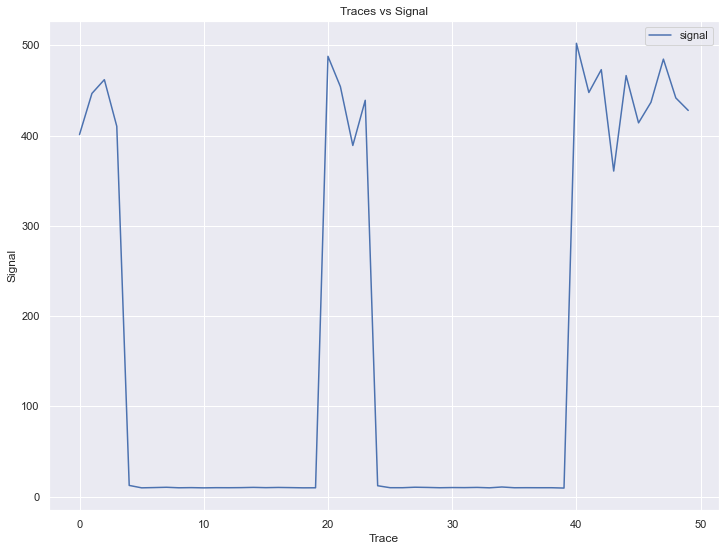

In [308]:
PATH_TO_TRACES_FILE = './traces_10000x50_int8.bin'
PATH_TO_PLAINTEXT_FILE = './plaintext_10000x16_uint8.bin'
#1st get the index of all the plaintext with firsbyte = 0x00 - 0xff
#2nd get vertical mean of traces with those index
#3rd get variance of all of those traces

#first snr = average over first column of trace
#second snr = average over first second column of trace
plaintextData = np.zeros(10000)
plaintextIndex = 0
with open(PATH_TO_PLAINTEXT_FILE, mode='rb') as f:
    while ((byte := f.read(16))):
        plaintextData[plaintextIndex] = int.from_bytes(byte[:1], "big")
        plaintextIndex +=1

traceData = np.zeros((10000,50))
traceIndex = 0
with open(PATH_TO_TRACES_FILE, mode='rb') as f:
    while ((byte := f.read(50))):
        for i in range(len(byte)):
            traceData[traceIndex][i] = byte[i]
        traceIndex+=1

## get list of vertical average traces[plaintext]
averageTraces = np.zeros([256, 50])
varianceTraces = np.zeros([256, 50])
for i in range(0,255):
    textFirstByteIndex = np.where(plaintextData == i)
    traceDataPlaintext = traceData[textFirstByteIndex]
    averageTraces[i] =  np.nanmean(traceDataPlaintext, axis=0)
    varianceTraces[i] = np.nanvar(traceDataPlaintext, axis=0)
    
signalArray = np.nanvar(averageTraces,axis=0)
noiseArray = np.nanmean(varianceTraces,axis=0)

plt.subplots(figsize=(12, 9))
plt.title("Traces vs Signal")
ax4 = sns.lineplot(x = list(range(50)), y = signalArray, label='signal')
ax4.set(xlabel='Trace', ylabel='Signal')
ax4.legend()
plt.show()

b. Noise of traces

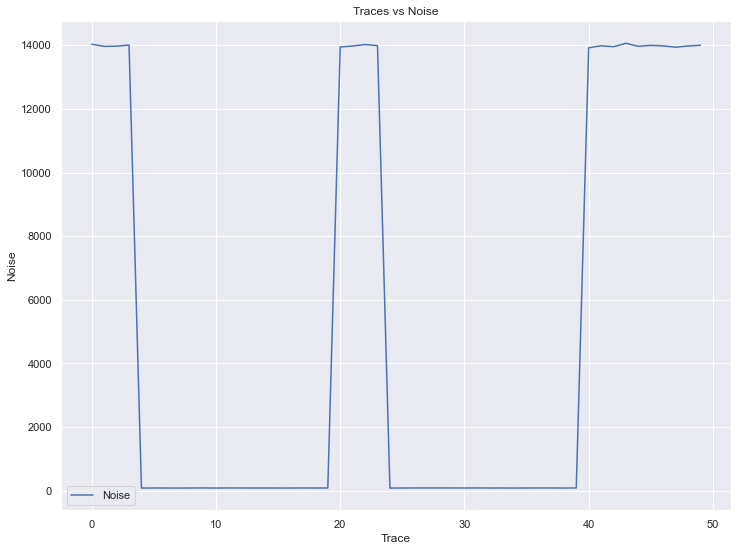

In [288]:
plt.subplots(figsize=(12, 9))
plt.title("Traces vs Noise")
ax4 = sns.lineplot(x = list(range(50)), y = noiseArray, label='Noise')
ax4.set(xlabel='Trace', ylabel='Noise')
ax4.legend()
plt.show()

c. SNR

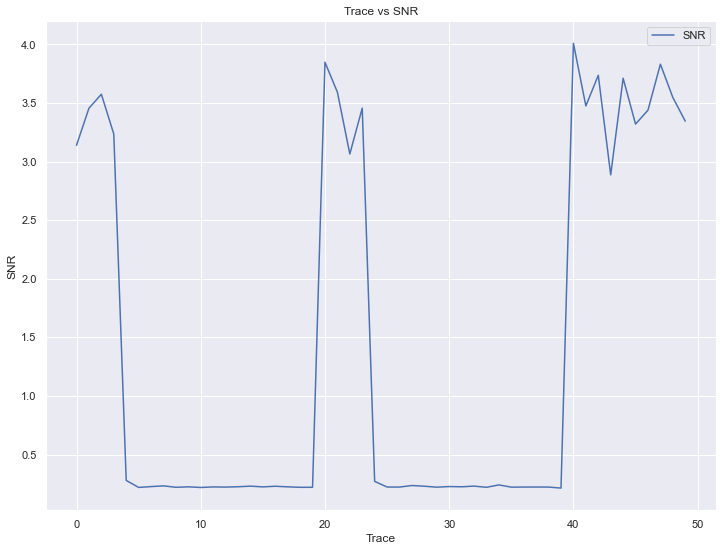

In [78]:
plt.subplots(figsize=(12, 9))
plt.title("Trace vs SNR")
ax4 = sns.lineplot(x = list(range(50)), y = np.divide(signalArray, noiseArray), label='SNR')
ax4.set(xlabel='Trace', ylabel='SNR')
ax4.legend()
plt.show()

 ## Part 3: CPA

In [279]:
sbox = np.array([
        0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
        0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
        0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
        0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
        0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
        0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
        0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
        0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
        0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
        0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
        0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
        0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
        0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
        0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
        0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
        0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

def countSetBits(n):
    count = 0
    while (n):
        count += n & 1
        n >>= 1
    return count

## arranging plaintext array
plaintextData = np.zeros([10000,16], dtype="int")
indexPlaintext = 0

with open(PATH_TO_PLAINTEXT_FILE, mode='rb') as f:
    while ((byte := f.read(16))):
        for i in range(len(byte)):
            plaintextData[indexPlaintext][i] = byte[i]
        indexPlaintext+=1

## arranging key hypotheses array
keyCandidates = np.arange(0,0x100)

## create power model array
def getPowerConsumptionOfKeyForBit(k,b):
    resultInt = sbox[np.bitwise_xor(plaintextData.T[b], k)]
    ret = np.zeros(10000)
    for j in range(len(resultInt)):
        ret[j] = countSetBits(resultInt[j])
    return ret


In [280]:
#getting the power model for every single plain text bits and trace hypothesis
powermodel = []
for b in tqdm(range(16)):
    mod = np.zeros([256,10000])
    for k in (keyCandidates):
        mod[k] = getPowerConsumptionOfKeyForBit(k, b)
    powermodel.append(mod)

  0%|          | 0/16 [00:00<?, ?it/s]

In [281]:
## arranging trace array
traceData = np.zeros((10000,50))
traceIndex = 0
with open(PATH_TO_TRACES_FILE, mode='rb') as f:
    while ((byte := f.read(50))):
        for i in range(len(byte)):
            traceData[traceIndex][i] = byte[i]
        traceIndex+=1

traceData = traceData.T

In [282]:
#Trace key:
def getResultMatrix(trace, textbit):
    ret = np.zeros(256)
    maxLikelyhood = 0
    maxIndex = 0
    for i in keyCandidates:
        powerModelatBit = powermodel[textbit]
        powerMean = np.mean(powerModelatBit[i])
        traceMean = np.mean(traceData[trace])
        p = powerModelatBit[i] - powerMean
        t = traceData[trace] - traceMean
        rij = np.sum(p*t)/(np.sqrt(np.sum(p**2)*np.sum(t**2)))
        ret[i] = rij 
        if rij > maxLikelyhood:
            maxLikelyhood = rij
            maxIndex = i
    return (maxIndex, ret)

In [283]:
## get keys for each trace for bits 0:
mostlikelyBit0Key = np.zeros(50)
resultMatrixBit0 = np.zeros([50,256])
for i in tqdm(range(50)):
    (maxIndex, ret) = getResultMatrix(i, 0)
    resultMatrixBit0[i] = ret
    mostlikelyBit0Key[i] = maxIndex

  0%|          | 0/50 [00:00<?, ?it/s]

In [284]:
np.where(mostlikelyBit0Key==237)
#this is a bit cheating since I use the given result to know which traces would contain the key

(array([24], dtype=int64),)

In [285]:
## get keys at trace 24 for the rest of the bits in plaintext
for bits in range(1,16):
    mostlikelyBit = np.zeros(50)
    resultMatrix = np.zeros([50,256])
    for i in range(50):
        (maxIndex, ret) = getResultMatrix(i, bits)
        resultMatrix[i] = ret
        mostlikelyBit[i] = maxIndex
    print(mostlikelyBit[24])

182.0
111.0
216.0
185.0
38.0
174.0
204.0
56.0
185.0
80.0
128.0
225.0
29.0
193.0
106.0
